In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision.transforms.functional import to_tensor
from torchvision import transforms
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import os
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
torch.cuda.empty_cache()

In [4]:
# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
])

In [5]:
# Training dataset path(edit here)
dataset=datasets.ImageFolder(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Train", transform=data_transforms) 

idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

idx_to_class

{0: 'Abhishek Bacchan',
 1: 'Amitabh Bacchan',
 2: 'George Clooney',
 3: 'Hugh Jackman',
 4: 'Matt Damon',
 5: 'Miley Cyrus',
 6: 'Morgan Freeman',
 7: 'Shahrukh Khan',
 8: 'Shakira',
 9: 'Will Smith'}

In [6]:
num_classes = len(idx_to_class)

In [7]:
# initializing mtcnn for face detection
mtcnn = MTCNN(image_size=240, margin=0, min_face_size=20) 

# Initialize InceptionResnetV1 models for face embedding
model1 = InceptionResnetV1(pretrained='vggface2').eval()
model2 = InceptionResnetV1(pretrained='casia-webface').eval()
model3 = InceptionResnetV1(num_classes=num_classes).eval()

# Prompt to use gpu if present 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)

In [18]:
def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

face_list = [] # list of cropped faces from photos folder
name_list = [] # list of names corrospoing to cropped photos
embedding_list1 = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet
embedding_list2 = []
embedding_list3 = []

for img, idx in loader:
    face, prob = mtcnn(img, return_prob=True) 
    if face is not None and prob>0.90: # if face detected and porbability > 90%
        face = face.to("cuda")
        # Pass cropped face through each model to get embedding matrices
        emb1 = model1(face.unsqueeze(0))
        emb2 = model2(face.unsqueeze(0))
        emb3 = model3(face.unsqueeze(0))
        
        # Store embedding matrices in respective lists
        embedding_list1.append(emb1.detach())
        embedding_list2.append(emb2.detach())
        embedding_list3.append(emb3.detach())
        
        name_list.append(idx_to_class[idx]) # names are stored in a list

In [19]:
data = [embedding_list1, embedding_list2, embedding_list3, name_list]
torch.save(data, 'data.pt') # here data contains the embedded matrix of each image corresponding to their name

In [20]:
def norm_data(data):
    mean = np.mean(data)
    std = np.std(data)
    normalized_data = [(value - mean) / std for value in data]
    return normalized_data


In [29]:
def face_match_average(img_path,data_path):
    img = Image.open(img_path)
    face, prob = mtcnn(img, return_prob=True)

    if face is not None and prob > 0.90:
        face = face.to(device)
        emb1 = model1(face.unsqueeze(0)).detach()
        emb2 = model2(face.unsqueeze(0)).detach()
        emb3 = model3(face.unsqueeze(0)).detach()
        
        saved_data = torch.load('data.pt')
#         embedding_list = saved_data[0]
        name_list = saved_data[3]
        dist_list = []
        dist1_list = []
        dist2_list = []
        dist3_list = []


        for idx, (emb_db1, emb_db2, emb_db3) in enumerate(zip(saved_data[0],saved_data[1],saved_data[2])):
            dist1 = torch.dist(emb1, emb_db1).item()
            dist2 = torch.dist(emb2, emb_db2).item()
            dist3 = torch.dist(emb3, emb_db3).item()
            
            dist1_list.append(dist1)
            dist2_list.append(dist2)
            dist3_list.append(dist3)

            class_name = name_list[idx]
            dist_list.append((dist1 + dist2 + 2*dist3) / 4)
        
        idx_min = dist_list.index(min(dist_list))
        
        dist1_list = norm_data(dist1_list)
        dist2_list = norm_data(dist2_list)
        dist3_list = norm_data(dist3_list)
        
        for idx in range (len(name_list)-1):
                dist_list[idx]  =  (dist1_list[idx] + dist2_list[idx] + dist3_list[idx])/3
        
        return (name_list[idx_min], min(dist_list))
    else:
        return None

In [30]:
def analysis(img_path,data_path):
    img = Image.open(img_path)
    face,prob = mtcnn(img,return_prob=True)
    
    if face is not None and prob > 0.90:
            face = face.to(device)
            emb1 = model1(face.unsqueeze(0)).detach()
            emb2 = model2(face.unsqueeze(0)).detach()
            emb3 = model3(face.unsqueeze(0)).detach()
        
            saved_data = torch.load('data.pt')
            embedding_list = saved_data[0]
            name_list = saved_data[3]
            dist_list = []
            dist1_list = []
            dist2_list = []
            dist3_list = []

            for idx, (emb_db1, emb_db2, emb_db3) in enumerate(zip(saved_data[0],saved_data[1],saved_data[2])):
                dist1 = torch.dist(emb1, emb_db1).item()
                dist2 = torch.dist(emb2, emb_db2).item()
                dist3 = torch.dist(emb3, emb_db3).item()
                
                dist1_list.append(dist1)
                dist2_list.append(dist2)
                dist3_list.append(dist3)
                
            dist1_list =  norm_data(dist1_list)
            dist2_list =  norm_data(dist2_list)
            dist3_list =  norm_data(dist3_list)
            
            for idx in range (len(name_list)-1):
                dist_list.append((dist1_list[idx] + dist2_list[idx] + dist3_list[idx]) / 3)
                print("Face Match: ",name_list[idx],'\nModel1:',dist1_list[idx],'\tModel2:',dist2_list[idx],'\tModel3:',dist3_list[idx],"\nAverage Distance: ",dist_list[idx],'\n\n')       

In [48]:
def check1(img_path, data_path, max_avg_distance = -0.6, max_single_distance = 0.6,name=None):
    img = Image.open(img_path)
    face, prob = mtcnn(img, return_prob=True)
    
    if face is not None and prob > 0.90:
        face = face.to(device)
        emb1 = model1(face.unsqueeze(0)).detach()
        emb2 = model2(face.unsqueeze(0)).detach()
        emb3 = model3(face.unsqueeze(0)).detach()
        
        saved_data = torch.load(data_path)
        embedding_list = saved_data[0]
        name_list = saved_data[3]
        dist1_list = np.zeros(len(name_list))
        dist2_list = np.zeros(len(name_list))
        dist3_list = np.zeros(len(name_list))
        class_dict = {}

        for idx, (emb_db1, emb_db2, emb_db3) in enumerate(zip(saved_data[0], saved_data[1], saved_data[2])):
            dist1 = torch.dist(emb1, emb_db1).item()
            dist2 = torch.dist(emb2, emb_db2).item()
            dist3 = torch.dist(emb3, emb_db3).item()
            
            dist1_list[idx] = dist1
            dist2_list[idx] = dist2
            dist3_list[idx] = dist3
            
            class_name = name_list[idx]
            if class_name not in class_dict:
                class_dict[class_name] = []
                
        dist1_list =  norm_data(dist1_list)
        dist2_list =  norm_data(dist2_list)
        dist3_list =  norm_data(dist3_list)         
        
        for idx in range(len(dist1_list)-1):
            class_dict[name_list[idx]].append((dist1_list[idx], dist2_list[idx], dist3_list[idx]))
            
        if name is not None:
            if name not in class_dict:
                print("Class", name, "not found in the data.")
                return False
            
            distances = class_dict[name]
            if len(distances) == 0:
                print("No distances found for class", name)
                return False
            avg_dist1 = sum(dist[0] for dist in distances) / len(distances)
            avg_dist2 = sum(dist[1] for dist in distances) / len(distances)
            avg_dist3 = sum(dist[2] for dist in distances) / len(distances)
            
            avg_dist = (avg_dist1+avg_dist2+avg_dist3)/3
            
            print("Class:", name)
            print("Average Distance:", avg_dist)
            
            if avg_dist < -2.0 or avg_dist1 < -2.0 or avg_dist2 < -0.8 :
                print('Face matches with:',name)
                return True
            
            if avg_dist > max_avg_distance:
                print("Average distance for class", name, "exceeds the maximum allowed distance.")
                return False 
                
            print("Model1:", avg_dist1, "\tModel2:", avg_dist2, "\tModel3:", avg_dist3)
                
            if avg_dist1 > max_single_distance or avg_dist2 > max_single_distance or avg_dist3 > max_single_distance :#
                print("Distance for class", name, "exceeds the maximum allowed distance for at least one model.")
                return False

            print('Face matches with:',name)
            return True
    else:
        print("No face detected or probability below threshold.")
        return False


In [45]:
#call the function to find the closest match to the embedded matrix which is created when passing the image path
name,dst = face_match_average(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Predict\Donald_Trump_official_portrait.jpg", 'data.pt')

if check1(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Predict\Donald_Trump_official_portrait.jpg", 'data.pt',0,-0.5,name) is True:
    print('Face matched with: ',name, 'With distance:',dst)
else:
    print('Face matches with None of the classes in Dataset')


Class: George Clooney
Average Distance: -0.5634942402271117
Model1: -0.929041103512506 	Model2: -0.615608853811691 	Model3: -0.14583276335713818
Distance for class George Clooney exceeds the maximum allowed distance for at least one model.
Face matches with None of the classes in Dataset


#### The code below will iterate all the images in the folder path given and predict which class(person) the image belongs to

In [50]:
# Set the path to the folder containing the images(Edit Here)
folder_path = r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Test\Hugh Jackman"

truth_val = os.path.basename(os.path.normpath(folder_path))
accuracy_list = []
acc_list = []
num_images=[]

for filename in os.listdir(folder_path):
    
    image_path = os.path.join(folder_path, filename)
    name,dst = face_match_average(image_path,'data.pt')
    
#     print('\nFace matched with: ',name, 'with distance: ',dst,'\tFilename:',filename)
    check1(image_path,'data.pt',name = name)
    print(filename,'\n\n')
        
    # Calculate accuracy
    accuracy = 1 if name == truth_val else 0
    accuracy_list.append(accuracy)
    
    acc_list.append(100*np.mean(accuracy_list))
    num_images.append(len(accuracy_list))

Class: Will Smith
Average Distance: -0.38564324302287595
Average distance for class Will Smith exceeds the maximum allowed distance.
test__000035-000000.jpg 


Class: Hugh Jackman
Average Distance: -1.1678645349503365
Face matches with: Hugh Jackman
test__000035-000001.jpg 


Class: Hugh Jackman
Average Distance: -0.7118202124416428
Model1: -1.2189539935735836 	Model2: -0.6184173736032079 	Model3: -0.29808927014813713
Face matches with: Hugh Jackman
test__000035-000002.jpg 


Class: Hugh Jackman
Average Distance: -0.944533473694254
Face matches with: Hugh Jackman
test__000035-000003.jpg 


Class: Hugh Jackman
Average Distance: -1.110679584793931
Face matches with: Hugh Jackman
test__000035-000004.jpg 


Class: Hugh Jackman
Average Distance: -1.1098848536059762
Face matches with: Hugh Jackman
test__000035-000005.jpg 


Class: Hugh Jackman
Average Distance: -1.0356749135976844
Face matches with: Hugh Jackman
test__000035-000006.jpg 


Class: Hugh Jackman
Average Distance: -1.136822343060

Class: Hugh Jackman
Average Distance: -0.8061173861752904
Model1: -1.6961472657578764 	Model2: -0.5994983328583787 	Model3: -0.12270655990961578
Face matches with: Hugh Jackman
train__000035-000018.jpg 


Class: Hugh Jackman
Average Distance: -0.7298677132751873
Model1: -1.9429677156330576 	Model2: -0.5492681586554307 	Model3: 0.30263273446292666
Face matches with: Hugh Jackman
train__000035-000020.jpg 


Class: Hugh Jackman
Average Distance: -1.210756978235699
Face matches with: Hugh Jackman
train__000035-000021.jpg 


Class: Hugh Jackman
Average Distance: -1.0062277461146951
Face matches with: Hugh Jackman
train__000035-000022.jpg 


Class: Hugh Jackman
Average Distance: -1.0853351125247852
Face matches with: Hugh Jackman
train__000035-000023.jpg 


Class: Hugh Jackman
Average Distance: -1.2782352262453422
Face matches with: Hugh Jackman
train__000035-000024.jpg 


Class: Will Smith
Average Distance: -0.18548460109082768
Average distance for class Will Smith exceeds the maximum allow

Class: Hugh Jackman
Average Distance: -1.048189000091999
Face matches with: Hugh Jackman
train__000035-000086.jpg 


Class: Hugh Jackman
Average Distance: -1.0755927499455282
Face matches with: Hugh Jackman
train__000035-000087.jpg 


Class: Hugh Jackman
Average Distance: -1.3352836669550403
Face matches with: Hugh Jackman
train__000035-000089.jpg 


Class: Hugh Jackman
Average Distance: -0.8061062032755206
Model1: -1.5879395513155907 	Model2: -0.48781286824453285 	Model3: -0.3425661902664381
Face matches with: Hugh Jackman
train__000035-000090.jpg 


Class: Hugh Jackman
Average Distance: -1.2352371492739505
Face matches with: Hugh Jackman
train__000035-000091.jpg 


Class: Hugh Jackman
Average Distance: -0.8087640382498642
Model1: -1.6020423828265344 	Model2: -0.6918575012503675 	Model3: -0.13239223067269074
Face matches with: Hugh Jackman
train__000035-000092.jpg 


Class: Hugh Jackman
Average Distance: -0.6526669116211772
Face matches with: Hugh Jackman
train__000035-000093.jpg 


C

<function matplotlib.pyplot.show(close=None, block=None)>

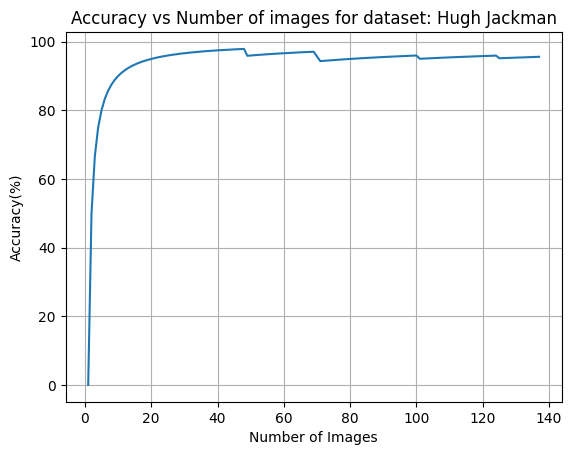

In [51]:
plt.plot(num_images,acc_list)
plt.xlabel('Number of Images')
plt.ylabel('Accuracy(%)')
tit = 'Accuracy vs Number of images for dataset: '+ truth_val
plt.title(tit)
plt.grid(True)
plt.show

In [52]:
acc = np.mean(accuracy_list)*100
print('Accuracy for',truth_val,'is:',acc)

Accuracy for Hugh Jackman is: 95.62043795620438


**This Code is for the clarity on how mtcnn detect faces it will detect multiple photos in the image if present**

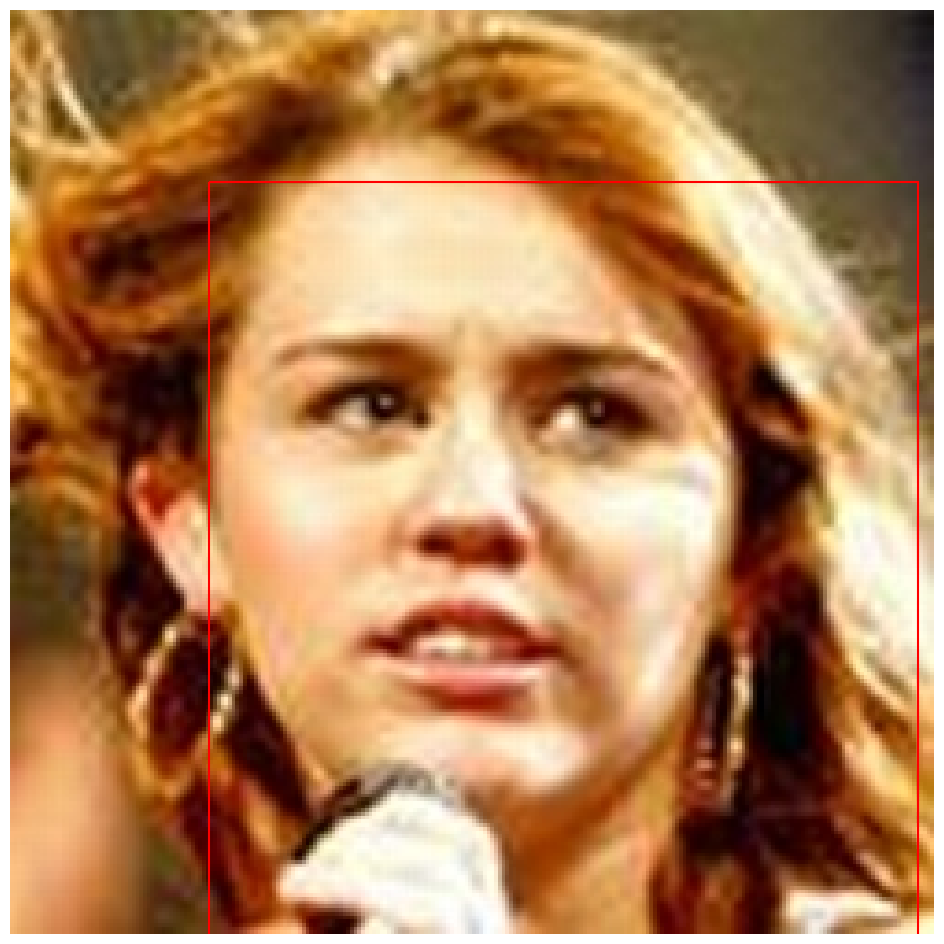

In [49]:
import matplotlib.pyplot as plt

# Load and preprocess the image
image = Image.open(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Test\Miley Cyrus\test__000061-000024.jpg")

# Perform face detection using MTCNN,this returns a bounding box(co-ordinates) 
#and its confidence score(probabiltiy that the bound has a face)
faces, _ = mtcnn.detect(image)

# Plot the image with bounding boxes around the detected faces
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(image)

# Draw bounding boxes around the detected faces
for face in faces:
    x, y, w, h = face
    rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=1.5)
    ax.add_patch(rect)

# Show the plot
plt.axis('off')
plt.show()


In [17]:
analysis(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Test\Miley Cyrus\test__000061-000024.jpg",'data.pt')

Face Match:  Abhishek Bacchan 
Model1: 0.47161264554824744 	Model2: 1.5526169992327574 	Model3: -0.9352051479280091 
Average Distance:  0.36300816561766514 


Face Match:  Abhishek Bacchan 
Model1: 1.5519900929982386 	Model2: 1.0707637062890567 	Model3: 0.024470425087646713 
Average Distance:  0.8824080747916474 


Face Match:  Abhishek Bacchan 
Model1: 0.8076042933375924 	Model2: 0.9299115527213188 	Model3: -0.6401123028766063 
Average Distance:  0.36580118106076825 


Face Match:  Abhishek Bacchan 
Model1: 0.5587586128214752 	Model2: -0.09972331793491666 	Model3: -0.3237274275213737 
Average Distance:  0.045102622455061615 


Face Match:  Abhishek Bacchan 
Model1: 1.115972341623107 	Model2: 1.7374759539425946 	Model3: -0.5079966961175508 
Average Distance:  0.7818171998160505 


Face Match:  Abhishek Bacchan 
Model1: 0.3966130004364532 	Model2: 0.9441523678282777 	Model3: 2.0625548063949233 
Average Distance:  1.1344400582198848 


Face Match:  Abhishek Bacchan 
Model1: 1.46493197671

In [19]:
analysis(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Predict\Donald_Trump_official_portrait.jpg",'data.pt')

Face Match:  Abhishek Bacchan 
Model1: 0.5070186921824077 	Model2: 2.2621944648013614 	Model3: -0.15560620605513262 
Average Distance:  0.8712023169762122 


Face Match:  Abhishek Bacchan 
Model1: 1.6093302048313523 	Model2: 3.067194475458063 	Model3: 1.6147317662007503 
Average Distance:  2.097085482163388 


Face Match:  Abhishek Bacchan 
Model1: 0.22898458932653018 	Model2: 1.6373837758131575 	Model3: -0.27884590737109377 
Average Distance:  0.5291741525895313 


Face Match:  Abhishek Bacchan 
Model1: 1.0409727737557544 	Model2: 0.3302018250985969 	Model3: -0.7382780291515741 
Average Distance:  0.21096552323425907 


Face Match:  Abhishek Bacchan 
Model1: 1.458444551454672 	Model2: 0.9294929540129372 	Model3: 0.9708312519486506 
Average Distance:  1.11958958580542 


Face Match:  Abhishek Bacchan 
Model1: -0.24192594167137454 	Model2: 1.5564140879145276 	Model3: 1.3556669806756059 
Average Distance:  0.8900517089729196 


Face Match:  Abhishek Bacchan 
Model1: 0.5108886976645277 	M

In [38]:
name,dst = face_match_average(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Predict\download (1).jpg", 'data.pt')

check1(r"C:\Users\jv258\Documents\Jupyter\Projects\Jodhpur\Images\Predict\download (1).jpg",'data.pt',0,0,name)

Class: Matt Damon
Average Distance: -0.20176241748999318
Distance for class Matt Damon exceeds the maximum allowed distance for at least one model.


False